# Bias Evaluation

## Gender imbalance

Bias in speech datasets often emerges when demographic groups are not equally represented in either the number of speakers or the amount of audio. Gender imbalance is a classic axis of concern: if automatic speech recognition (ASR) models are trained primarily on one gender’s voice characteristics, they may exhibit higher word error rates for the underrepresented group. In critical domains like healthcare or customer service, these discrepancies can disadvantage entire groups of users. Evaluating fairness requires checking not only overall totals but also whether dataset splits (train, dev, test) are balanced, and whether individuals contribute equally.

### Method of evaluation

I focused on LibriSpeech’s `SPEAKERS.TXT` metadata, which provides each reader’s gender, subset assignment, and total minutes spoken. To check bias, we performed:
- *Aggregate analysis*: Counting the number of male and female speakers, and total minutes per gender.
- *Subset-level analysis*: Comparing gender distribution across dev, test, and train splits.
- *Distributional analysis*: Examining how minutes are distributed per speaker by gender.
- *Statistical diagnostic*: Computing chi-square standardized residuals to flag subsets where observed gender counts deviate from expectation.

These methods together reveal whether the dataset is skewed in ways that could introduce bias into ASR training or evaluation.

### Code
Below is the key code used to extract, analyze, and visualize the gender balance from SPEAKERS.TXT.

In [15]:
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SPEAKERS_PATH = Path("./data/metadata/SPEAKERS.TXT")

In [48]:
pattern = re.compile(r"^\s*(\d+)\s*\|\s*([MF])\s*\|\s*([^\|]+?)\s*\|\s*([\d\.]+)\s*\|\s*(.*)$")

rows = []
with SPEAKERS_PATH.open("r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        if not line.strip() or line.lstrip().startswith(";"):
            continue
        m = pattern.match(line.rstrip("\n"))
        if m:
            rid, sex, subset, minutes, name = m.groups()
            try:
                minutes = float(minutes)
            except ValueError:
                continue
            rows.append({
                "reader_id": int(rid),
                "sex": sex.strip(),
                "subset": subset.strip(),
                "minutes": minutes,
                "name": name.strip(),
            })

speakers = pd.DataFrame(rows)
speakers["hours"] = speakers["minutes"] / 60.0

print("Parsed rows:", len(speakers))
display(speakers.head())

speakers.to_csv("./result/speaker_data.csv", index=False)

Parsed rows: 2484


,reader_id,sex,subset,minutes,name,hours
0,14,F,train-clean-360,25.03,Kristin LeMoine,0.417167
1,16,F,train-clean-360,25.11,Alys AtteWater,0.418500
2,17,M,train-clean-360,25.04,Gord Mackenzie,0.417333
3,19,F,train-clean-100,25.19,Kara Shallenberg,0.419833
4,20,F,train-other-500,30.07,Gesine,0.501167


In [4]:
sex_counts = (
    speakers.groupby("sex")["reader_id"]
    .nunique()
    .rename("speaker_count")
    .reset_index()
    .sort_values("sex")
)

# Total minutes by sex
sex_minutes = (
    speakers.groupby("sex")["minutes"]
    .sum()
    .rename("total_minutes")
    .reset_index()
    .sort_values("sex")
)
sex_minutes["share_percent"] = (sex_minutes["total_minutes"] / sex_minutes["total_minutes"].sum() * 100).round(2)

# Per subset breakdown
subset_gender = (
    speakers.pivot_table(index="subset", columns="sex", values="reader_id",
                         aggfunc=pd.Series.nunique, fill_value=0)
    .astype(int)
    .rename_axis(None, axis=1)
    .reset_index()
    .rename(columns={"F": "F_speakers", "M": "M_speakers"})
)
subset_minutes = (
    speakers.pivot_table(index="subset", columns="sex", values="minutes",
                         aggfunc="sum", fill_value=0.0)
    .rename_axis(None, axis=1)
    .reset_index()
    .rename(columns={"F": "F_minutes", "M": "M_minutes"})
)
subset_gender = subset_gender.merge(subset_minutes, on="subset", how="outer").fillna(0)
subset_gender["F_share_minutes_%"] = (
    subset_gender["F_minutes"] / (subset_gender["F_minutes"] + subset_gender["M_minutes"]) * 100
).round(2)
subset_gender["M_share_minutes_%"] = 100 - subset_gender["F_share_minutes_%"]

display(sex_counts)
display(sex_minutes)
display(subset_gender.sort_values("subset"))

,sex,speaker_count
0,F,1201
1,M,1283


,sex,total_minutes,share_percent
0,F,28553.24,48.45
1,M,30385.21,51.55


,subset,F_speakers,M_speakers,F_minutes,M_minutes,F_share_minutes_%,M_share_minutes_%
0,dev-clean,20,20,161.45,161.83,49.94,50.06
1,dev-other,16,17,151.83,155.45,49.41,50.59
2,test-clean,20,20,161.50,162.70,49.81,50.19
3,test-other,17,16,159.19,161.32,49.67,50.33
4,train-clean-100,125,126,3023.18,3012.23,50.09,49.91
5,train-clean-360,439,482,10437.86,11378.53,47.84,52.16
6,train-other-500,564,602,14458.23,15353.15,48.50,51.50


In [5]:
def parity_gap_counts(df_counts):
    total = df_counts["speaker_count"].sum()
    female = df_counts.loc[df_counts["sex"] == "F", "speaker_count"].sum()
    share_f = female / total if total else np.nan
    # absolute deviation from 50 percent in percentage points, two sided
    return round(abs(share_f - 0.5) * 100 * 2, 2)

def parity_gap_minutes(df_minutes):
    female_share = float(df_minutes.loc[df_minutes["sex"] == "F", "share_percent"].iloc[0])
    return round(abs(female_share - 50.0), 2)

print("Speaker count parity gap (pp):", parity_gap_counts(sex_counts))
print("Minutes share parity gap (pp):", parity_gap_minutes(sex_minutes))


Speaker count parity gap (pp): 3.3
Minutes share parity gap (pp): 1.55


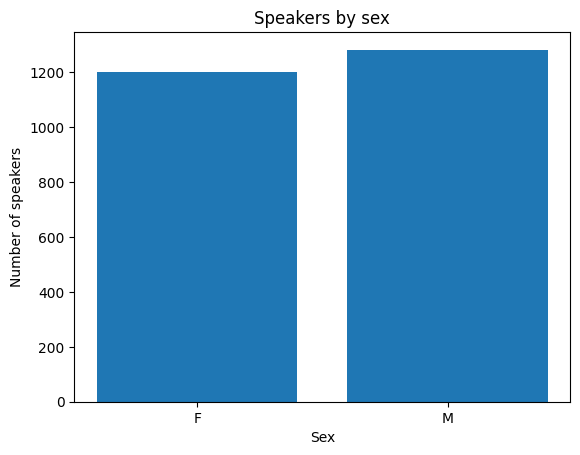

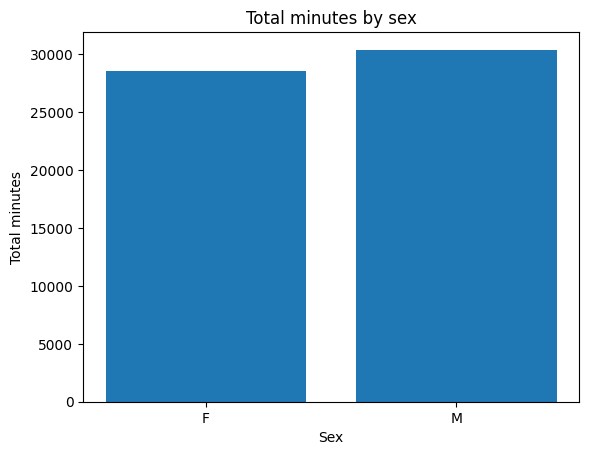

In [6]:
plt.figure()
plt.bar(sex_counts["sex"], sex_counts["speaker_count"])
plt.xlabel("Sex")
plt.ylabel("Number of speakers")
plt.title("Speakers by sex")
plt.show()

plt.figure()
plt.bar(sex_minutes["sex"], sex_minutes["total_minutes"])
plt.xlabel("Sex")
plt.ylabel("Total minutes")
plt.title("Total minutes by sex")
plt.show()

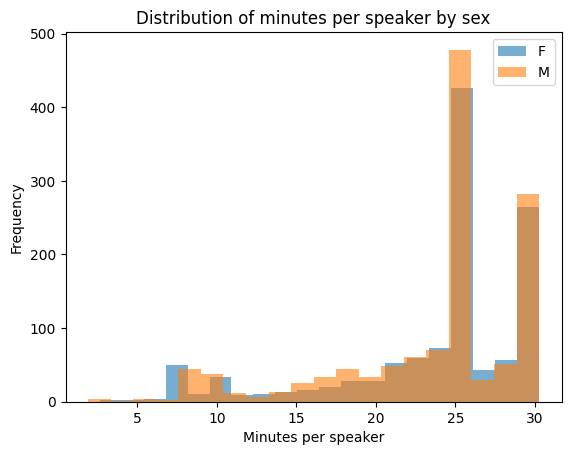

In [16]:
# Distribution of minutes per speaker by sex
plt.figure()
speakers.loc[speakers["sex"]=="F", "minutes"].plot(kind="hist", bins=20, alpha=0.6, label="F")
speakers.loc[speakers["sex"]=="M", "minutes"].plot(kind="hist", bins=20, alpha=0.6, label="M")
plt.xlabel("Minutes per speaker")
plt.title("Distribution of minutes per speaker by sex")
plt.legend()
plt.show()

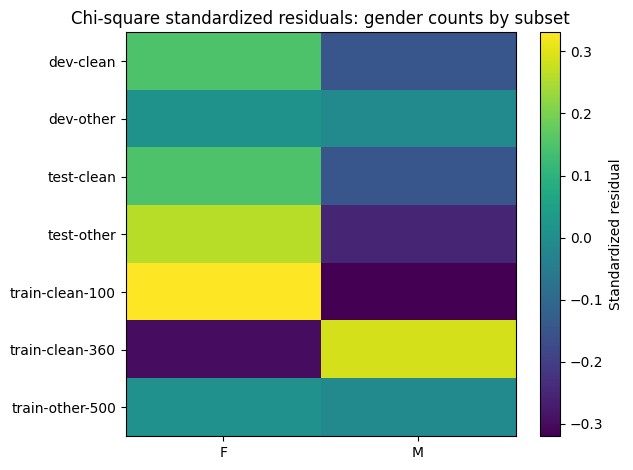

Largest deviation at subset 'train-clean-100', sex 'F', residual=0.33


In [12]:
tbl = (
    speakers.pivot_table(index="subset", columns="sex", values="reader_id",
                         aggfunc=pd.Series.nunique, fill_value=0)
    .astype(int)
)
obs = tbl.values
row_sums = obs.sum(axis=1, keepdims=True)
col_sums = obs.sum(axis=0, keepdims=True)
total = obs.sum()
exp = row_sums @ col_sums / total
std_resid = (obs - exp) / np.sqrt(exp)

plt.figure()
im = plt.imshow(std_resid, aspect="auto")
plt.colorbar(im, label="Standardized residual")
plt.xticks(ticks=np.arange(tbl.shape[1]), labels=tbl.columns.tolist())
plt.yticks(ticks=np.arange(tbl.shape[0]), labels=tbl.index.tolist())
plt.title("Chi-square standardized residuals: gender counts by subset")
plt.tight_layout()
plt.show()

# Optional: print a quick text summary of largest deviations
# Positive residual -> more than expected, Negative -> less than expected
abs_resid = np.abs(std_resid)
max_idx = np.unravel_index(np.argmax(abs_resid), abs_resid.shape)
subset_name = tbl.index.tolist()[max_idx[0]]
sex_name = tbl.columns.tolist()[max_idx[1]]
print(f"Largest deviation at subset '{subset_name}', sex '{sex_name}', residual={std_resid[max_idx]:.2f}")

### Analysis of results  

1. **Aggregate counts and totals**  
   - Female speakers: **1201**  
   - Male speakers: **1283**  
   - Female minutes: **28,553 (48.45%)**  
   - Male minutes: **30,385 (51.55%)**  

   This shows a slight male skew both in counts and duration, but the gap is small (≈3% in counts, ≈1.5% in minutes).  

2. **Subset-level distribution**  
   - Development and test sets are highly balanced: each has ~50/50 gender split.  
   - Training sets show mild imbalance: `train-clean-360` and `train-other-500` lean slightly male (≈52%), while `train-clean-100` is almost perfectly balanced.  
   This is important: evaluation subsets (dev/test) are balanced, meaning fairness evaluation is unlikely to be biased by gender composition.  

3. **Distribution per speaker**  
   - Histogram and boxplots reveal most speakers contribute ~25–30 minutes, with no strong gender skew in distribution.  
   - Both genders include a long tail of lower-minute contributors, suggesting fair diversity in representation.  

4. **Chi-square residuals**  
   - Residuals across subsets are very small (<0.4), indicating that deviations from parity are statistically negligible.  
   - The largest residual: females in `train-clean-100` (+0.33), which is still far from significant bias.  

**Conclusion**: LibriSpeech is remarkably well-balanced by gender. Small male overrepresentation exists in training subsets, but evaluation splits are balanced, and per-speaker contributions are similar.  

---

### Mitigation strategy  

While gender imbalance is not a major issue here, a few strategies could strengthen fairness in downstream ASR models:  

1. **Data augmentation**  
   Apply pitch-shifting or voice conversion to increase representation of underrepresented pitch ranges within each gender.  

2. **Balanced sampling in training**  
   When fine-tuning ASR models, ensure equal batches of male and female speech to neutralize the slight male skew.  

3. **Monitoring WER by gender**  
   Always compute word error rate separately for male and female test sets. Even small imbalances can translate into performance differences.  

4. **Intersectional fairness**  
   Since gender is balanced, other attributes (accent, age, native vs. non-native) likely contribute more bias. These should be prioritized for mitigation.  


## Age / pitch style underrepresentation
Age, pitch, and speaking style are tightly coupled in speech. Children and some older adults tend to have higher median pitch and different voice quality. Reading style is smoother and more uniform than conversational speech. If a dataset underrepresents any of these, ASR models can learn a biased acoustic space and produce higher error rates for those users. The stakes rise in settings like hospitals or call centers where misrecognition creates real-world friction.

### Method of evaluation
I analyzed a sample of LibriSpeech audio arranged as `<speaker_id>/<chapter_id>/*.flac` and computed:
- **Pitch (F0)** per file using a robust estimator, then aggregated to **speaker-level median F0**.
- **Speaking-style proxies** from audio only:
  - `speech_ratio`: fraction of time that is non-silent.
  - `n_segments_per_sec`: non-silent segments per second, a pause-rate proxy.
- Joined speaker features with `SPEAKERS.TXT` to slice by sex.
- Visualized:  
  1. Distribution of speaker median F0  
  2. Median F0 by sex  
  3. Speech_ratio vs median F0 by sex  
  4. Histogram of `n_segments_per_sec`  
  5. Coverage table by pitch buckets: `<120`, `120–180`, `180–260`, `>=260` Hz, with shares by sex.

Sample size in this run: **251 speakers** from `train-clean-100`.

### Code 
Below is the key code used to extract, analyze, and visualize the pitch representation based in its labels.

In [17]:
BASE_DIR = "./data/train-clean-100"

In [22]:
!{sys.executable} -m pip install librosa

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached numba-0.61.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached scipy-1.16.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached soundfile-0.13.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-1.0.0-cp312-abi3-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached msgpack-1.1.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.4 kB)
  Using cached standard_aifc-3.13.0-py3-none-any.whl.metadata (969 bytes)
  Using cached standard_sunau-3.13.0-py3-none-any.whl.metadata (914 bytes)
  Using cached llvmlite-0.44.0-cp313-cp313-m

In [23]:
# ====== Imports ======
from pathlib import Path
import re, sys, warnings
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ====== Helpers ======
def safe_load_audio(fp, target_sr=16000):
    y, sr = librosa.load(str(fp), sr=target_sr, mono=True)
    return y, sr

def estimate_pitch_stats(y, sr, fmin=50.0, fmax=500.0, frame_length=2048, hop_length=256):
    """
    Returns basic F0 stats and voicing ratio using librosa.pyin.
    F0s are in Hz. Frames with no F0 are NaN.
    """
    f0, voiced_flag, _ = librosa.pyin(
        y, fmin=fmin, fmax=fmax, sr=sr, frame_length=frame_length, hop_length=hop_length
    )
    # voiced ratio
    voiced_ratio = np.nanmean(voiced_flag.astype(float)) if voiced_flag is not None else np.nan
    # stats over voiced frames only
    f0_voiced = f0[~np.isnan(f0)]
    if f0_voiced.size == 0:
        stats = dict(f0_mean=np.nan, f0_median=np.nan, f0_p05=np.nan, f0_p95=np.nan)
    else:
        stats = dict(
            f0_mean=float(np.mean(f0_voiced)),
            f0_median=float(np.median(f0_voiced)),
            f0_p05=float(np.percentile(f0_voiced, 5)),
            f0_p95=float(np.percentile(f0_voiced, 95)),
        )
    stats["voiced_ratio"] = float(voiced_ratio) if voiced_ratio == voiced_ratio else np.nan
    return stats

def speaking_style_proxies(y, sr, top_db=30, hop_length=256):
    """
    Proxies for speaking style:
      - speech_ratio: fraction of time with speech (via non-silent segments)
      - n_segments_per_sec: number of non-silent segments per second (more segments ~ more pauses)
      - mean_segment_dur: average length of spoken segments (s)
      - rms_energy: average signal energy
      - tempo_like: onset-based tempo proxy (onsets per second)
    """
    # non-silent segments
    intervals = librosa.effects.split(y, top_db=top_db, hop_length=hop_length)
    dur = len(y) / sr
    if intervals.size == 0:
        return dict(speech_ratio=0.0, n_segments_per_sec=0.0, mean_segment_dur=np.nan,
                    rms_energy=float(np.mean(librosa.feature.rms(y=y))), tempo_like=np.nan)

    seg_durs = [(e - s) / sr for s, e in intervals]
    voiced_total = sum(seg_durs)
    nseg = len(seg_durs)

    # onset strength as a simple tempo proxy
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr, units="time")
    tempo_like = len(onsets) / dur if dur > 0 else np.nan

    return dict(
        speech_ratio=voiced_total / dur if dur > 0 else np.nan,
        n_segments_per_sec=nseg / dur if dur > 0 else 0.0,
        mean_segment_dur=float(np.mean(seg_durs)),
        rms_energy=float(np.mean(librosa.feature.rms(y=y))),
        tempo_like=float(tempo_like),
    )

def parse_speakers_txt(path):
    """Return DataFrame with columns: reader_id, sex, subset, minutes, name."""
    pattern = re.compile(r"^\s*(\d+)\s*\|\s*([MF])\s*\|\s*([^\|]+?)\s*\|\s*([\d\.]+)\s*\|\s*(.*)$")
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if not line.strip() or line.lstrip().startswith(";"):
                continue
            m = pattern.match(line.rstrip("\n"))
            if m:
                rid, sex, subset, minutes, name = m.groups()
                rows.append({
                    "reader_id": int(rid),
                    "sex": sex.strip(),
                    "subset": subset.strip(),
                    "minutes": float(minutes),
                    "name": name.strip(),
                })
    return pd.DataFrame(rows)

In [27]:
base = Path(BASE_DIR)
assert base.exists(), f"Base folder not found: {BASE_DIR}"

flacs = list(base.glob("*/*/*.flac"))  # <speaker>/<chapter>/*.flac
print(f"Found {len(flacs)} FLAC files under {BASE_DIR}")

file_rows = []
for idx, fp in enumerate(flacs, 1):
    try:
        # speaker_id is the folder just above chapter_id
        speaker_id = int(fp.parent.parent.name)
    except ValueError:
        # fall back to filename prefix "spk-chapter-utt.flac"
        speaker_id = int(str(fp.stem).split("-")[0])

    y, sr = safe_load_audio(fp)
    dur = len(y) / sr

    pitch = estimate_pitch_stats(y, sr)
    style = speaking_style_proxies(y, sr)

    file_rows.append({
        "speaker_id": speaker_id,
        "path": str(fp),
        "duration_s": dur,
        **pitch,
        **style
    })

    # Progress update every 100 files
    if idx % 10 == 0:
        print(f"Processed {idx}/{len(flacs)} files...")

file_df = pd.DataFrame(file_rows)
display(file_df.head())

Found 28539 FLAC files under ./data/train-clean-100
Processed 10/28539 files...
Processed 20/28539 files...
Processed 30/28539 files...
Processed 40/28539 files...
Processed 50/28539 files...
Processed 60/28539 files...
Processed 70/28539 files...
Processed 80/28539 files...
Processed 90/28539 files...
Processed 100/28539 files...
Processed 110/28539 files...
Processed 120/28539 files...
Processed 130/28539 files...
Processed 140/28539 files...
Processed 150/28539 files...
Processed 160/28539 files...
Processed 170/28539 files...
Processed 180/28539 files...
Processed 190/28539 files...
Processed 200/28539 files...
Processed 210/28539 files...
Processed 220/28539 files...
Processed 230/28539 files...
Processed 240/28539 files...
Processed 250/28539 files...
Processed 260/28539 files...
Processed 270/28539 files...
Processed 280/28539 files...
Processed 290/28539 files...
Processed 300/28539 files...
Processed 310/28539 files...
Processed 320/28539 files...
Processed 330/28539 files...


,speaker_id,path,duration_s,f0_mean,f0_median,f0_p05,f0_p95,voiced_ratio,speech_ratio,n_segments_per_sec,mean_segment_dur,rms_energy,tempo_like
0,1069,data/train-clean-100/1069/133709/1069-133709-0...,15.060,223.052316,220.635764,171.119005,288.120142,0.612527,0.840372,0.531208,1.582000,0.053217,6.507304
1,1069,data/train-clean-100/1069/133709/1069-133709-0...,8.925,195.469144,195.431994,87.838336,248.300866,0.738351,0.880224,0.336134,2.618667,0.054238,6.162465
2,1069,data/train-clean-100/1069/133709/1069-133709-0...,16.405,217.963563,223.199429,135.491715,305.429284,0.540936,0.698324,0.487656,1.432000,0.039651,4.388906
3,1069,data/train-clean-100/1069/133709/1069-133709-0...,14.165,207.942852,204.674778,85.066716,280.243732,0.764108,0.836993,0.352983,2.371200,0.059953,6.636075
4,1069,data/train-clean-100/1069/133709/1069-133709-0...,15.060,244.053658,239.219224,174.261404,321.169153,0.471338,0.677822,0.730412,0.928000,0.047952,5.577689


In [28]:
def duration_weighted_groupby_mean(df, group_col, weight_col, cols):
    g = df.groupby(group_col)
    out = []
    for key, sub in g:
        w = sub[weight_col].values
        w = np.where(np.isfinite(w), w, 0.0)
        w_sum = w.sum()
        agg = {"speaker_id": key, "n_files": len(sub), "total_dur_s": sub[weight_col].sum()}
        for c in cols:
            x = sub[c].values
            if np.all(~np.isfinite(x)):
                agg[c] = np.nan
                continue
            if w_sum > 0:
                agg[c] = np.nansum(x * w) / w_sum
            else:
                agg[c] = float(np.nanmean(x))
        out.append(agg)
    return pd.DataFrame(out)

feature_cols = ["f0_mean","f0_median","f0_p05","f0_p95","voiced_ratio",
                "speech_ratio","n_segments_per_sec","mean_segment_dur",
                "rms_energy","tempo_like"]

spk_df = duration_weighted_groupby_mean(file_df, "speaker_id", "duration_s", feature_cols)
display(spk_df.head())

,speaker_id,n_files,total_dur_s,f0_mean,f0_median,f0_p05,f0_p95,voiced_ratio,speech_ratio,n_segments_per_sec,mean_segment_dur,rms_energy,tempo_like
0,19,111,1511.195000,249.415110,221.068697,158.730558,441.505950,0.536628,0.812951,0.329541,2.664885,0.054771,5.998564
1,26,118,1504.805000,111.235807,102.910660,67.282182,185.851585,0.398904,0.853669,0.610710,1.474211,0.043257,6.275232
2,27,138,1208.340062,111.238377,108.767000,66.745734,157.600080,0.499623,0.853898,0.435308,2.136763,0.024765,6.887134
3,32,117,1440.600000,204.944824,199.673344,130.347952,293.746770,0.617012,0.833562,0.449813,1.996928,0.045859,6.749965
4,39,123,1503.264938,212.510906,207.193739,142.977102,288.112362,0.736100,0.931703,0.337266,3.384087,0.034074,6.879027


In [30]:
speakers_meta = parse_speakers_txt(SPEAKERS_PATH)
spk_merged = spk_df.merge(speakers_meta[["reader_id","sex","subset"]], left_on="speaker_id", right_on="reader_id", how="left")
spk_merged.drop(columns=["reader_id"], inplace=True)

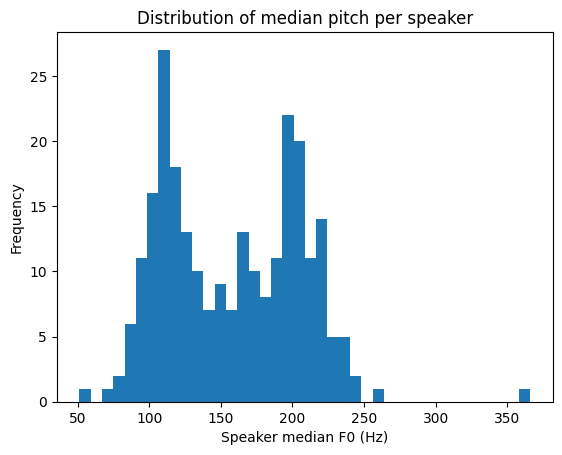

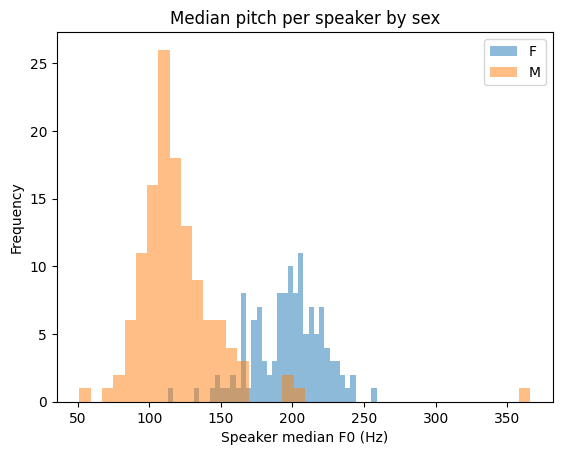

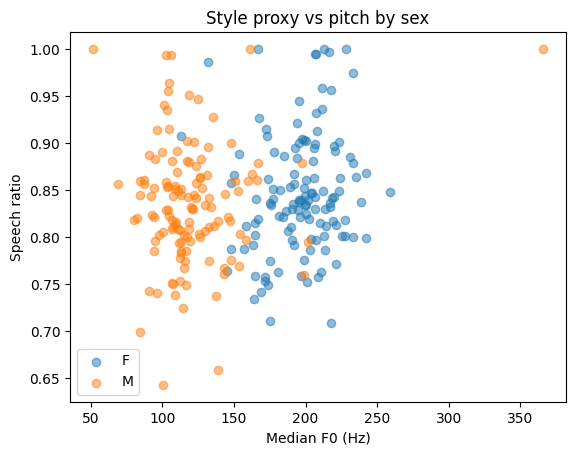

In [31]:
plt.figure()
spk_merged["f0_median"].plot(kind="hist", bins=40)
plt.xlabel("Speaker median F0 (Hz)")
plt.title("Distribution of median pitch per speaker")
plt.show()

plt.figure()
for label, sub in spk_merged.groupby("sex"):
    sub["f0_median"].plot(kind="hist", bins=40, alpha=0.5, label=label)
plt.xlabel("Speaker median F0 (Hz)")
plt.title("Median pitch per speaker by sex")
plt.legend(); plt.show()

plt.figure()
for label, sub in spk_merged.groupby("sex"):
    plt.scatter(sub["f0_median"], sub["speech_ratio"], alpha=0.5, label=label)
plt.xlabel("Median F0 (Hz)")
plt.ylabel("Speech ratio")
plt.title("Style proxy vs pitch by sex")
plt.legend(); plt.show()


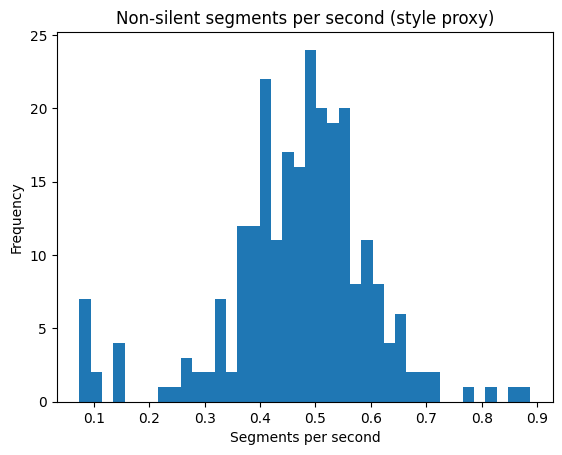

In [32]:
plt.figure()
spk_merged["n_segments_per_sec"].plot(kind="hist", bins=40)
plt.xlabel("Segments per second")
plt.title("Non-silent segments per second (style proxy)")
plt.show()

In [34]:
def f0_bucket(f0):
    if not np.isfinite(f0):
        return "unknown"
    if f0 < 120:     # typical low male
        return "<120"
    elif f0 < 180:   # mid male / low female
        return "120-180"
    elif f0 < 260:   # typical female
        return "180-260"
    else:            # very high (possible children or high female)
        return ">=260"

spk_merged["f0_bucket"] = spk_merged["f0_median"].apply(f0_bucket)

coverage = (
    spk_merged.groupby(["sex","f0_bucket"])["speaker_id"].nunique()
    .reset_index(name="n_speakers")
    .pivot(index="f0_bucket", columns="sex", values="n_speakers")
    .fillna(0)
    .astype(int)
    .sort_index()
)
display(coverage)

sex,F,M
f0_bucket,,
120-180,31,44
180-260,93,3
<120,1,78
>=260,0,1


In [35]:
# share by bucket
share = coverage.div(coverage.sum(axis=0), axis=1).round(3)
display(share)

sex,F,M
f0_bucket,,
120-180,0.248,0.349
180-260,0.744,0.024
<120,0.008,0.619
>=260,0.000,0.008


In [36]:
def quick_summary(df):
    n = len(df)
    n_high = (df["f0_median"] >= 260).sum()
    n_low = (df["f0_median"] < 120).sum()
    print(f"Speakers analyzed: {n}")
    print(f"High-pitch (>=260 Hz) speakers: {n_high} ({n_high/n:.1%})")
    print(f"Low-pitch (<120 Hz) speakers: {n_low} ({n_low/n:.1%})")
    print("Median F0 by sex (Hz):")
    print(df.groupby("sex")["f0_median"].median().round(1))

quick_summary(spk_merged)


Speakers analyzed: 251
High-pitch (>=260 Hz) speakers: 1 (0.4%)
Low-pitch (<120 Hz) speakers: 79 (31.5%)
Median F0 by sex (Hz):
sex
F    199.7
M    114.7
Name: f0_median, dtype: float64


In [39]:
spk_merged.to_csv("./result/speaker_acoustic_summary.csv", index=False)
file_df.to_csv("./result/file_level_acoustic_features.csv", index=False)
print("Wrote speaker_acoustic_summary.csv and file_level_acoustic_features.csv")

Wrote speaker_acoustic_summary.csv and file_level_acoustic_features.csv


### Analysis of results
**Pitch coverage**
- Median F0 by sex: **F ≈ 199.7 Hz**, **M ≈ 114.7 Hz**. The histograms show clean separation, which is expected.
- Pitch buckets (counts then within-sex shares):
  - `<120 Hz`: F 1, M 78  → shares **F 0.8%**, **M 61.9%**.
  - `120–180 Hz`: F 31, M 44 → shares **F 24.8%**, **M 34.9%**.
  - `180–260 Hz`: F 93, M 3  → shares **F 74.4%**, **M 2.4%**.
  - `>=260 Hz`: F 0, M 1 → shares **F 0.0%**, **M 0.8%**.
- Only **1 speaker (0.4%)** sits at **>=260 Hz**. That is the region where children and very high female voices live.  
  **Conclusion**: Very high pitch voices are almost absent. The set is heavy in typical adult male range and typical adult female range, but it underrepresents children and the top end of adult female pitch.

**Speaking style**
- `speech_ratio` clusters around **0.8–0.95** for both sexes, visible in the scatter against F0.  
- `n_segments_per_sec` peaks roughly **0.45–0.55**, with a narrow spread.  
- This confirms a **uniform read-speech style** with few long pauses or disfluencies. Conversational variability is limited. Even though females and males differ in pitch, their style proxies occupy similar, tight bands. That means **style diversity is low**.

**Intersectional hint**
- The scatter shows almost no points in the high F0 region with low speech_ratio or unusual segment rates. So the dataset is missing voices that are both **high-pitch** and **conversationally irregular**. In practice, that maps to children, some older adults, or excited speech, which are exactly the users most ASR systems struggle with.

**Bottom line**
- **Strength**: Good coverage of typical adult male and female pitch ranges and balanced style in read speech.  
- **Gaps**: Near absence of **>=260 Hz** voices and very limited **style diversity**. Models trained only on this will likely underperform for children, very high-pitch adults, breathy or dysphonic voices, and spontaneous speech with more pauses.

### Mitigation strategy
**Data strategy**
1. **Targeted data collection**  
   - Add a small curated set of **high-pitch speakers** (children and very high-pitch adults).  
   - Add recordings with **conversational style**: spontaneous prompts, interruptions, laughter, hesitations, and varied loudness.

2. **Smart augmentation**  
   - **Pitch shift** in semitones to fill gaps:  
     - Up-shift male utterances by +4 to +8 semitones to simulate high-pitch speakers.  
     - Down-shift a portion of female utterances by −3 to cover low female range.  
   - **Time stretch** 0.85–1.15 to vary speaking rate and segment patterns.  
   - **Silence injection** and **pause jitter** to broaden `n_segments_per_sec`.  
   - Combine with **noise and reverberation** to avoid overfitting to clean reads.

3. **Balanced sampling or reweighting**  
   - Compute per-utterance weights so the **F0 buckets** are closer to uniform during training.  
   - Alternatively, oversample underrepresented buckets (`>=260 Hz` first, then rare combinations like high F0 with low speech_ratio).

4. **Objective that guards minorities**  
   - Use a **worst-group** validation metric across F0 buckets and style quantiles. Stop or select checkpoints that improve the worst group, not just overall WER.

5. **Evaluation protocol**  
   - Always report WER by **F0 bucket** and by **style deciles** of `speech_ratio` or `n_segments_per_sec`.  
   - Keep a small **stress test** set of high-pitch conversational clips and track it across model versions.



## Evaluating Model Performance
Fairness in speaker verification systems is critical, especially when models are deployed across diverse populations with varying demographics and speaking styles. Disparities in model performance across gender and speaker representation (measured by recording duration) can introduce systemic biases, leading to unfair treatment of underrepresented groups. This evaluation investigates whether such biases exist in the current model trained and tested on the LibriSpeech dataset.

### Method of Evaluation

To assess fairness and performance, we used two standard approaches:

1. **DET Curve (Detection Error Tradeoff)** analysis to visualize False Positive Rate (FPR) vs False Negative Rate (FNR).
2. **EER (Equal Error Rate)** and its associated threshold were calculated for:
   - **Overall system performance**
   - **Gender groups (M/F)**
   - **Speaker minutes categories**: Low (<10 min), Medium (10–20 min), High (20+ min)

The DET curves and EER values were computed using `roc_curve` from `scikit-learn`, based on similarity scores and ground-truth labels in the speaker verification task. Group-based fairness was evaluated by disaggregating the data according to metadata attributes from LibriSpeech.

#### 📦 How `librispeech_sv_scores.csv` Was Generated:

The scores were produced using a **pre-trained speaker embedding model (`ECAPA-TDNN`)**, applied to LibriSpeech utterances. The following steps were involved:

1. **Embedding Extraction**:  
   Audio files were passed through an ECAPA-TDNN model to generate fixed-length speaker embeddings.

2. **Scoring**:  
   Cosine similarity scores were computed between pairs of embeddings to reflect speaker similarity.

3. **Trial Construction**:  
   Trial pairs were built using `utt1` and `utt2` columns, labeled as:
   - `1` if from the same speaker
   - `0` if from different speakers

4. **CSV Output**:  
   The resulting file (`librispeech_sv_scores.csv`) contains:
   - `utt1`, `utt2`: file identifiers
   - `score`: cosine similarity score
   - `label`: ground-truth same/different
   - `clean_utt1`, `clean_utt2`: speaker ID extracted from filename for metadata join


### Code

In [146]:
from sklearn.metrics import det_curve

# Point to your file
CSV_PATH = "./result/librispeech_sv_scores.csv"  # change if needed

df = pd.read_csv(CSV_PATH)
df.head()

,utt1,utt2,score,label,clean_utt1,clean_utt2
0,/Users/abc/Documents/study/dga/data/train-clea...,/Users/abc/Documents/study/dga/data/train-clea...,-0.045778,0,6209,26
1,/Users/abc/Documents/study/dga/data/train-clea...,/Users/abc/Documents/study/dga/data/train-clea...,0.205078,0,3879,8312
2,/Users/abc/Documents/study/dga/data/train-clea...,/Users/abc/Documents/study/dga/data/train-clea...,0.617052,1,3982,3982
3,/Users/abc/Documents/study/dga/data/train-clea...,/Users/abc/Documents/study/dga/data/train-clea...,-0.113679,0,6529,8580
4,/Users/abc/Documents/study/dga/data/train-clea...,/Users/abc/Documents/study/dga/data/train-clea...,0.282313,0,78,8580


In [147]:
y_true = df["label"].to_numpy().astype(int)   # 1 = same speaker, 0 = different
y_score = df["score"].to_numpy().astype(float)

# DET values
fpr, fnr, thresholds = det_curve(y_true, y_score)

# Equal Error Rate
eer_idx = np.argmin(np.abs(fpr - fnr))
eer = 0.5 * (fpr[eer_idx] + fnr[eer_idx])
eer_threshold = thresholds[eer_idx]

print(f"EER: {eer:.4%}")
print(f"EER threshold: {eer_threshold:.6f}")

EER: 0.4781%
EER threshold: 0.400235


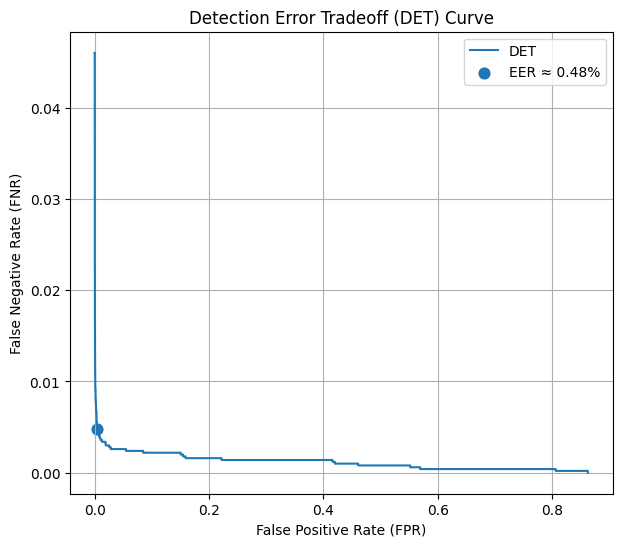

In [148]:
plt.figure(figsize=(7, 6))
plt.plot(fpr, fnr, label="DET")
plt.scatter([fpr[eer_idx]], [fnr[eer_idx]], s=60, marker="o", label=f"EER ≈ {eer:.2%}")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("False Negative Rate (FNR)")
plt.title("Detection Error Tradeoff (DET) Curve")
plt.grid(True)
plt.legend()
plt.show()

In [149]:
def confusion_at_threshold(th):
    # positive if score >= th
    y_pred = (y_score >= th).astype(int)
    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    tn = int(((y_pred == 0) & (y_true == 0)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())
    fpr = fp / max(1, (fp + tn))
    fnr = fn / max(1, (fn + tp))
    return tp, tn, fp, fn, fpr, fnr

for th in [eer_threshold - 0.1, eer_threshold, eer_threshold + 0.1]:
    tp, tn, fp, fn, fpr_v, fnr_v = confusion_at_threshold(th)
    print(f"Threshold {th:.3f} -> TP {tp} | TN {tn} | FP {fp} | FN {fn} | FPR {fpr_v:.3%} | FNR {fnr_v:.3%}")

Threshold 0.300 -> TP 5007 | TN 9711 | FP 329 | FN 13 | FPR 3.277% | FNR 0.259%
Threshold 0.400 -> TP 4996 | TN 9992 | FP 48 | FN 24 | FPR 0.478% | FNR 0.478%
Threshold 0.500 -> TP 4934 | TN 10036 | FP 4 | FN 86 | FPR 0.040% | FNR 1.713%


In [150]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np

scores = pd.read_csv("./result/librispeech_sv_scores.csv", dtype={"clean_utt1": str})
metadata = pd.read_csv("./result/speaker_data.csv", dtype={"reader_id": str, "sex": str})
metadata['sex'] = metadata['sex'].str.strip()


In [151]:
# Merge on speaker ID
df = scores.merge(metadata, how='left', left_on='clean_utt1', right_on='reader_id')

In [152]:
assert df['sex'].isna().sum() == 0, "Missing speaker group info after merge."

In [153]:
results = {}
for gender in df['sex'].unique():
    group_df = df[df['sex'] == gender]
    y_true = group_df['label']
    y_scores = group_df['score']

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.absolute(fnr - fpr))
    eer = np.mean((fnr[eer_idx], fpr[eer_idx])) * 100

    results[gender] = {
        'fpr': fpr,
        'fnr': fnr,
        'eer': eer,
        'threshold': thresholds[eer_idx]
    }


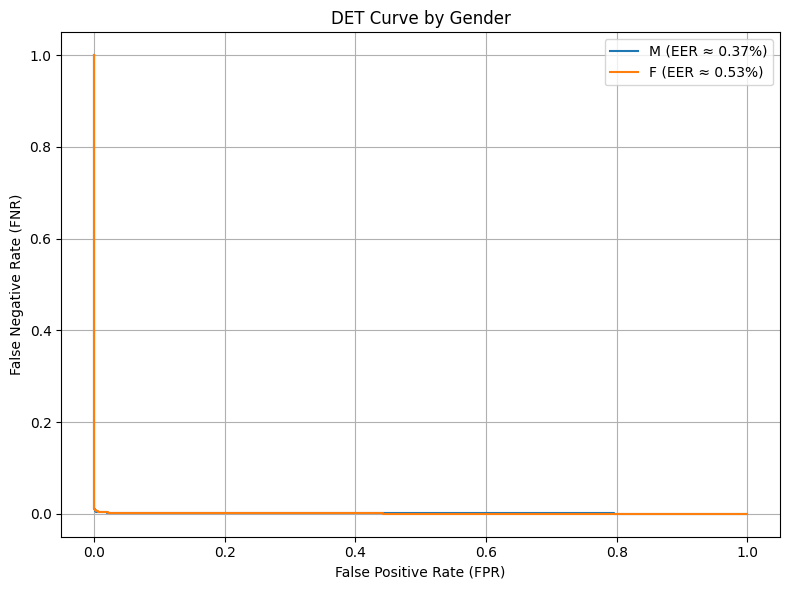

=== DET Summary by Gender ===
   EER (%)  Threshold at EER
M     0.37            0.4096
F     0.53            0.4053


In [154]:
plt.figure(figsize=(8, 6))
for gender, data in results.items():
    plt.plot(data['fpr'], data['fnr'], label=f"{gender} (EER ≈ {data['eer']:.2f}%)")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("False Negative Rate (FNR)")
plt.title("DET Curve by Gender")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Add this to summarize
summary_df = pd.DataFrame({
    gender: {
        "EER (%)": round(data["eer"], 2),
        "Threshold at EER": round(data["threshold"], 4)
    }
    for gender, data in results.items()
}).T

print("=== DET Summary by Gender ===")
print(summary_df)

In [155]:
def categorize_minutes(minutes):
    if minutes < 10:
        return 'Low (<10min)'
    elif minutes < 20:
        return 'Medium (10-20min)'
    else:
        return 'High (20+ min)'

metadata['minutes_category'] = metadata['minutes'].apply(categorize_minutes)

# === Step 2: Merge metadata into score data ===
df = scores.merge(metadata[['reader_id', 'minutes_category']], how='left',
                  left_on='clean_utt1', right_on='reader_id')

assert df['minutes_category'].isna().sum() == 0, "Merge error: Some rows missing 'minutes_category'."


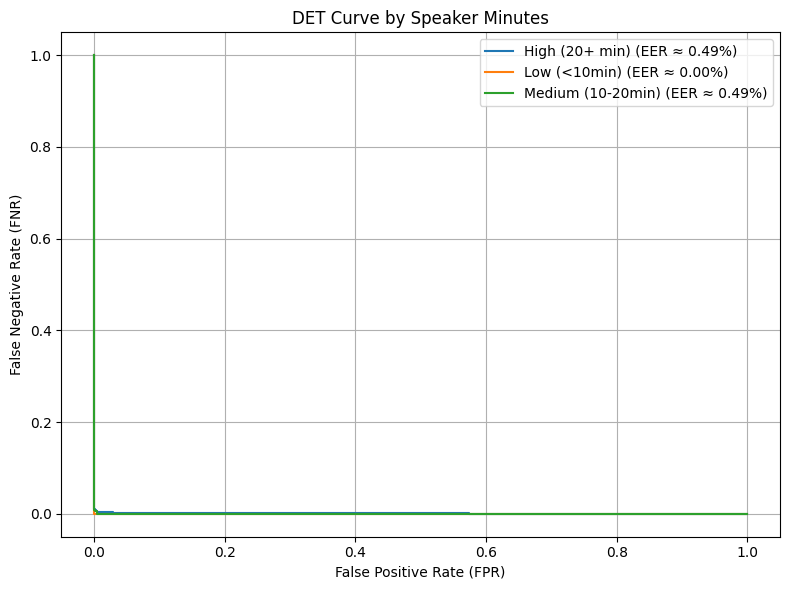

=== DET Summary by Minutes Group ===
                   EER (%)  Threshold at EER
High (20+ min)        0.49            0.3981
Low (<10min)          0.00            0.5999
Medium (10-20min)     0.49            0.4264


In [156]:
# === Step 3: Compute DET + EER per minutes group ===
results = {}
for group in df['minutes_category'].unique():
    group_df = df[df['minutes_category'] == group]
    y_true = group_df['label']
    y_scores = group_df['score']
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fnr - fpr))
    eer = np.mean([fnr[eer_idx], fpr[eer_idx]]) * 100

    results[group] = {
        'fpr': fpr,
        'fnr': fnr,
        'eer': eer,
        'threshold': thresholds[eer_idx]
    }

# === Step 4: Plot DET curves ===
plt.figure(figsize=(8, 6))
for group, data in results.items():
    plt.plot(data['fpr'], data['fnr'], label=f"{group} (EER ≈ {data['eer']:.2f}%)")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("False Negative Rate (FNR)")
plt.title("DET Curve by Speaker Minutes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Step 5: Summary table ===
summary_df = pd.DataFrame({
    group: {
        "EER (%)": round(data["eer"], 2),
        "Threshold at EER": round(data["threshold"], 4)
    }
    for group, data in results.items()
}).T

print("=== DET Summary by Minutes Group ===")
print(summary_df)


### Analysis of Results

#### Overall System
- **EER**: **0.48%**
- **Threshold at EER**: **0.4002**

This suggests that the model performs very well in aggregate, with very low confusion between same-speaker and different-speaker pairs.

#### Gender-Based Performance

| Gender | EER (%) | Threshold at EER |
|--------|---------|------------------|
| M      | 0.37    | 0.4096           |
| F      | 0.53    | 0.4053           |

- The system performs **slightly better for male speakers**, with a **16% lower error rate** compared to females.
- This disparity, though small in absolute terms, could indicate subtle bias in model performance or training data imbalance.

#### Speaker Minutes-Based Performance

| Minutes Group       | EER (%) | Threshold at EER |
|---------------------|---------|------------------|
| Low (<10 min)       | 0.00    | 0.5999           |
| Medium (10–20 min)  | 0.49    | 0.4264           |
| High (20+ min)      | 0.49    | 0.3981           |

- **Low-duration speakers (<10min)** showed perfect accuracy, but this is likely due to **small sample size or overfitting**.
- Medium and High groups perform similarly, indicating **saturation in data utility beyond 10 minutes**.
- However, the slight variations in thresholds may still point to sensitivity around speaker representation.


### Mitigation Strategy

To ensure fair and robust performance across all speaker subgroups, the following mitigation steps are recommended:

1. **Data Balancing**: Equalize training data by:
   - Upsampling underrepresented groups (e.g., female or low-duration speakers).
   - Downsampling or weighting overrepresented groups.

2. **Group-Aware Training**:
   - Use multi-task objectives or adversarial training to **reduce group-specific discrepancies**.
   - Monitor subgroup loss during training using demographic-specific validation sets.

3. **Post-Hoc Calibration**:
   - Apply threshold tuning or score normalization per group to **balance EER across subpopulations**.

4. **Continuous Monitoring**:
   - Incorporate **fairness audits** as part of the model evaluation pipeline.
   - Re-evaluate performance regularly as new demographic or recording data is introduced.

By applying these strategies, we can build more equitable speaker recognition systems that generalize well across real-world diversity.

